### Paketimporte

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Vorbereitung der Daten

Preise

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

Downtime

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

Kundendaten

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

Vereinen der Transaktionsdaten

In [5]:
def read_regio_data(region, kind):
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

### Vegleich der verschiedenen Modelle

Im Folgenden vergleichen wir die verschiedenen Tablet-Modelle in

- Gewinnmargen
- Verkaufszahlen

Und schlüsseln diese anschließend nach jedem Marktplatz auf. Hierzu fangen wir an mit den Gewinnmargen.

Wir untersuchen zuerst den Gewinn pro Stück.

<Axes: xlabel='product', ylabel='profit_per_unit'>

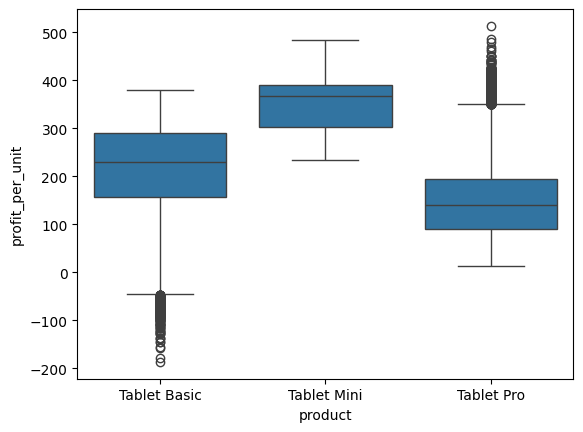

In [6]:
# Gewinnmargen für die drei Produkte basic, mini und pro darstellen
sns.boxplot(x="product", y="profit_per_unit", data=df_reg_main)

Wir sehen hier, dass das Tablet Basic als einziges Produkt Verluste erzielt. Der Durchschnitt des Basics ist jedoch über dem Pro. Am besten ist das Mini mit dem durchschnittlich höchsten Gewinn pro Stück. Das Pro besitzt also einen niedrigen Durchschnitt dieser besitzt jedoch Ausreißert nach oben.

Weitergehend betrachten wir den Gewinn pro Stück im zeitlichen Verlauf auf die verschiedenen Tablet Modelle aufgeschlüsselt.

/var/folders/0z/hf0hhysx25v4c8md4jfmz7kr0000gn/T/ipykernel_34207/1164010019.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


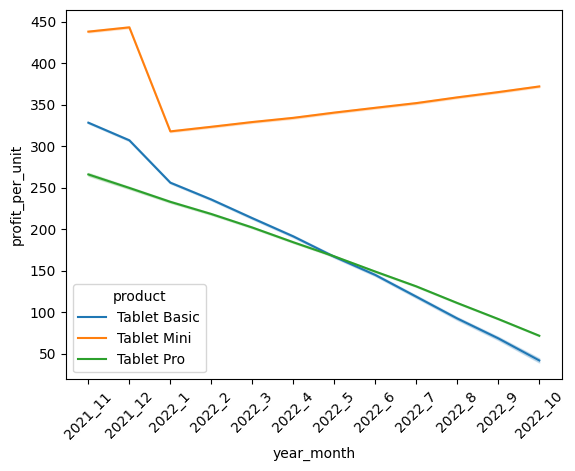

In [16]:
plot = sns.lineplot(x="year_month", y="profit_per_unit", hue="product", data=df_reg_main)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

Zu sehen ist, dass der Gewinn des Tablet Minis zum Jahreswechsel abfällt, jedoch danach kontinuierlich ansteigt. Im Vergleich dazu sinkt der Gewinn des Pro Modells und des Basics immer weiter ab.

Um zu prüfen, ob dies mit den Preisen zusammenhängt betrachten wir diese anschließend.

In [7]:
df_price.head(6)

,year,product,price
0,2021,Tablet Pro,999
1,2022,Tablet Pro,999
2,2021,Tablet Mini,680
3,2022,Tablet Mini,550
4,2021,Tablet Basic,529
5,2022,Tablet Basic,499


Wir beobachten eine Absenkung des Preises des Tablet Basics und Minis. Ein Gewinnabfall zum Jahreswechsel ist also nachvollziehbar. Jedoch sinkt der Gewinn selbst nach dem Jahreswechsel von dem Tablet Basic immer weiter. Gleichzeitig sinkt auch der Gewinn des Tablet Pros, trotz eines gleichbleibenden Preises.

Diese Faktoren weisen auf zu hohe Kosten hin. Wir betrachten also im Folgenden einmal die Kosten pro Stück auf die verschiedenen Modelle aufgeteilt.

<Axes: xlabel='product', ylabel='cost_per_unit'>

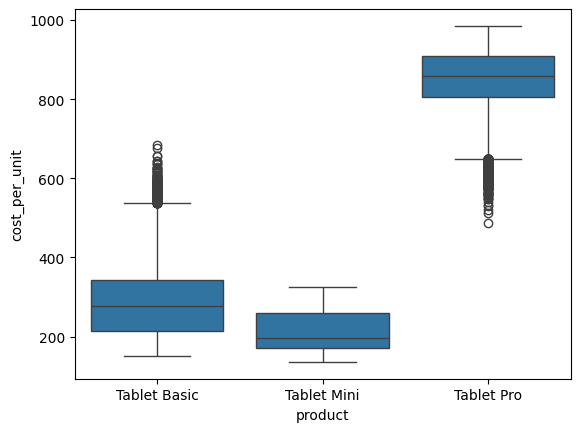

In [9]:
sns.boxplot(x="product", y="cost_per_unit", data=df_reg_main)

Für das Tablet Basic ist zu sehen, dass es einige Werte für die Kosten gibt, welche die Preise übersteigen. Damit ist erklärbar, wie die Verlusttransaktionen entstehen. Im Falle des Pro-Modells ist ein Durchschnitt der Kosten zu erkennen, welcher sehr nah am Preis liegt. Dieser Zustand erläutert die geringen Gewinne des Tablet Pros, trotz eines hohen Preises. Im Vergleich zu diesen beiden Modellen zeigt sich das Tablet Mini mit wenigen Ausreißern in den Kosten. Gleichzeitig sind diese auf einem stabilen niedrigen Niveau.

Zusammenfasend sahen wir in der Gewinnmargenanalyse, dass das Pro- und Basic-Modell beide zu hohe Kosten für zu niedrige Preise besitzen. In zukünftigen Untersuchungen sollte daher geprüft werden, wie diese Kosten entstehen.

#### Verkaufszahlen

Wir beginnen die Betrachtung der Verkaufszahlen mit der Erstellung eines Boxplots für die Verkaufszahlen pro Transaktion. Dies wird auf die drei Tablet-Modelle aufgeschlüsselt.

<Axes: xlabel='product', ylabel='amount'>

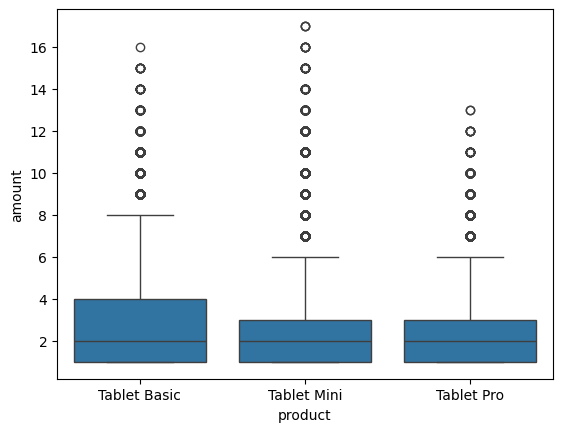

In [10]:
# Verkaufszahlen der drei Produkte basic, mini und pro darstellen
sns.boxplot(x="product", y="amount", data=df_reg_main)

Wir sehen für alle drei Modelle ungefähr die gleichen durchschnittlichen Verkaufsmengen pro Transaktion. Hierbei besitzt das Tablet Pro die geringsten maximalen Verkaufsmengen. Das Mini zeichnet sich hier besonders ab, wobei das Basic-Modell nicht viel weniger Stück pro Transaktion verkauft hat. Das Basic zeichnet sich jedoch in der durchschnittlichen Verkaufsmenge leicht von den anderen Modellen ab. Diese liegt etwas höher.

Aufgrund des ersten Eindrucks betrachten wir nun einmal die Werte in konkreten Zahlen.

In [18]:
df_reg_main.groupby(['product'])['amount'].mean()

product
Tablet Basic    2.815223
Tablet Mini     2.513773
Tablet Pro      2.119953
Name: amount, dtype: float64

Wir sehen hierfür wie in dem Boxplot ersichtlich ein ungefähr gleiches Spektrum an durchschnittlichen Verkäufen pro Transaktion. Das Tablet Basic besitzt eine etwas größere Verkaufsmenge als die anderen beiden Modelle. Jedoch reiht sich das Mini nah an das Basic an. Nur das Pro besitzt eine recht geringe Verkaufsmenge pro Transaktion. Diese Tendenz lässt sich im ersten Moment durch die unterschiedlichen Preise begründen.

Betrachten wir weitergehend die absolute Menge an verkauften Produkten.

In [23]:
df_reg_main.groupby(['product'])['amount'].sum()

product
Tablet Basic    211854
Tablet Mini     276515
Tablet Pro      317993
Name: amount, dtype: int64

Hier ist die Tendenz tatsächlich umgekehrt zur durchschnittlichen Verkaufsmenge pro Transaktion. Das Basic besitzt mit 200 Tsd. die geringste Anzahl an verkauften Produkten. Das Pro liegt hierbei mit über 300 Tsd. am höchsten. In der Mitte reiht sich wieder das Mini-Modell ein.

Um diese umgekehrte Tendenz zu erklären, dass absolut von dem Pro-Modell am meisten verkauft wurden, begutachten wir nun die durchschnittliche Kundenbewertung der drei Tablet-Modelle.

In [12]:
df_reg_main.groupby(['product'])['customer_rating'].mean()

product
Tablet Basic    5.597655
Tablet Mini     8.013835
Tablet Pro      8.273344
Name: customer_rating, dtype: float64

In den Kundenbewertungen spiegeln sich die Verkaufszahlen wider. Das Basic-Modell ist am schlechtesten bewertet und wurde daher am wenigsten verkauft. Währenddessen ist das Pro-Modell am besten bewertet und besitzt damit einhergehend die höchsten Verkaufszahlen. Eine Korrelation zwischen der Kundenbewertung und den Verkaufszahlen ist nicht auszuschließen.

Da wir in den Transaktionen einen umgekehrten Trend zu den absoluten Verkaufszahlen beobachteten, analysieren wir abschließend die durchschnittliche Verkaufsmenge im zeitlichen Verlauf.

/var/folders/0z/hf0hhysx25v4c8md4jfmz7kr0000gn/T/ipykernel_23671/744313651.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


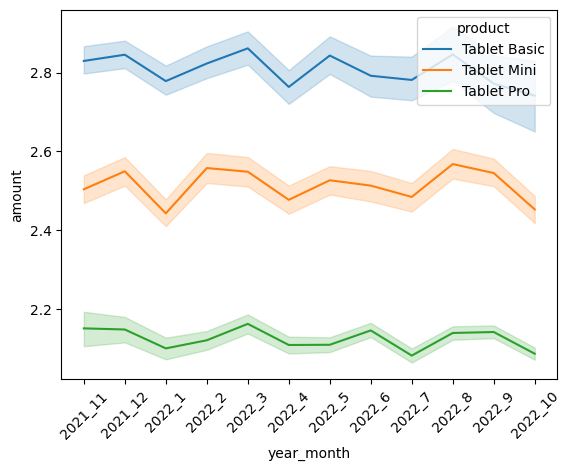

In [13]:
plot = sns.lineplot(x="year_month", y="amount", hue="product", data=df_reg_main)
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plt.show()

Im zeitlichen Verlauf zeigt sich kein klarer Trend bezüglich der Verkaufszahlen. Weder sinkt ein Modell ab, noch steigt eines an. Es scheint also kein anhaltender Trend erkennbar zu sein.

Bei den Verkaufsmengen lässt sich zusammenfassen, dass das Pro-Modell sich von allen Modellen am meisten verkauft hat. Gleichzeitig werden jedoch pro Transaktion am wenigsten von diesem verkauft. Dies wird wahrscheinlich an den hohen Stückpreisen liegen. DAs Mini-Modell hält sich von den drei Modellen am besten. Mit einer guten Kundenbewertung, einer Verkaufsmenge pro Transaktion im Mittelfeld, sowie einer absoluten Verkaufsmenge im Mittelfeld. Gleichzeitig zeigten wir, dass eine Korrelation zwischen Kundenbewertung und Verkaufsmenge besteht.

#### Nach Markplatz aufschlüsseln

Im Folgenden betrachten wir die Kennzahlen der Produkte auf die Marktplätze aufgeschlüsselt. Konkret wollen wir die Frage untersuchen, ob der Gewinn in Stores wegen bestimmter Modelle sinkt.

Zuerst betrachten wir die Verkaufszahlen pro Transaktion in einem Boxplot.

<Axes: xlabel='product', ylabel='amount'>

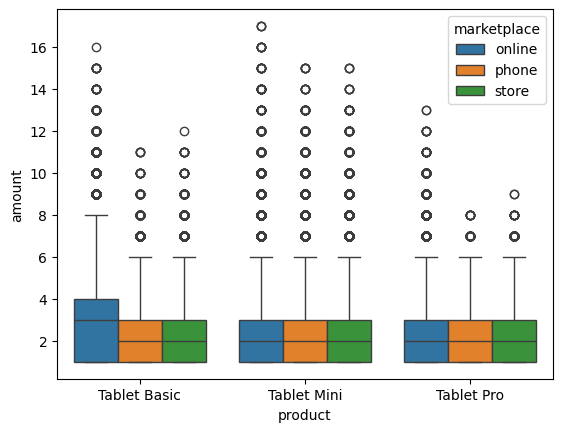

In [14]:
sns.boxplot(x="product", y="amount", hue="marketplace", data=df_reg_main)

Für die verschiedenen Modelle sind einige Trends anhaltend. Zum einen ist zu sehen, dass das Tablet Basic durchschnittlich im Onlinehandel am meisten verkauft wurde. Ansonsten ist der durchschnittlich verkaufte Wert auf dem Telefonmarktplatz und den Stores sehr ähnlich. Beim Tablet Minit sieht man deutliche Ausreißer nach oben, wobei hier der Onlinehandel ebenfalls dominiert. Telefon und Stores sind sich hier ebenfalls sehr ähnlich. Zuletzt stellen wir für das Pro-Modell fest, dass die Verkaufsmengen wie bereits beobachtet wieder abfallen. Hierbei ist besonders der Telefonhandel niedriger als die anderen Marktplätze. Dennoch gibt es für alle drei Modelle pro Marktplatz keine großen Unterschiede außer dem Basic-Modell im Onlinehandel.

Genauer betrachten wir das Ganze via Pandas.

In [15]:
df_reg_main.groupby(['product', 'marketplace'])['amount'].mean()

product       marketplace
Tablet Basic  online         2.947354
              phone          2.574840
              store          2.591037
Tablet Mini   online         2.815108
              phone          2.435970
              store          2.441162
Tablet Pro    online         2.435414
              phone          2.085969
              store          2.084329
Name: amount, dtype: float64

Hier sehen wir nun, dass das Basic-Modell und das Mini-Modell sich in den durchschnittlichen Verkaufsmengen pro Transaktion nicht groß unterscheiden. Das Mini liegt nur leicht unter dem Basic. Jedoch ist für das Pro ein leichter Abstieg erkennbar. Insgesamt zeichnet sich jedoch ab, dass der Telefonmarktplatz und die Stores recht gleich auf mit den durchschnittlichen Verkaufsmengen pro Transaktion.

Wir analysieren nun im Folgenden die absoluten Verkaufsmengen der Produkte über die Marktplätze hinweg.

In [16]:
df_reg_main.groupby(['product', 'marketplace'])['amount'].sum()

product       marketplace
Tablet Basic  online         141081
              phone           29433
              store           41340
Tablet Mini   online          62273
              phone          133669
              store           80573
Tablet Pro    online          36558
              phone           93539
              store          187896
Name: amount, dtype: int64

In diesem Fall beobachten wir deutliche Diskrepanzen zwischen den verschiedenen Marktplätze. Das Basic-Modell wird am meisten im Onlinehandel verkauft. Das Mini-Modell im Telefonhandel und zuletzt das Pro-Modell in den Stores.

Erkennbar ist also, dass der niedrige Gewinn des Tablet Pros sich auf die Stores auswirkt. Zukünftig sollte also beleuchtet werden, was für ein Gewicht die Korrelation zwischen dem Pro-Modell und den Stores besitzt.

Weitergehend betrachten wir den Gewinn pro Stück in einem zeitlichen Verlauf auf die Marktplätze geschlüsselt.

<Axes: xlabel='year_month', ylabel='profit_per_unit'>

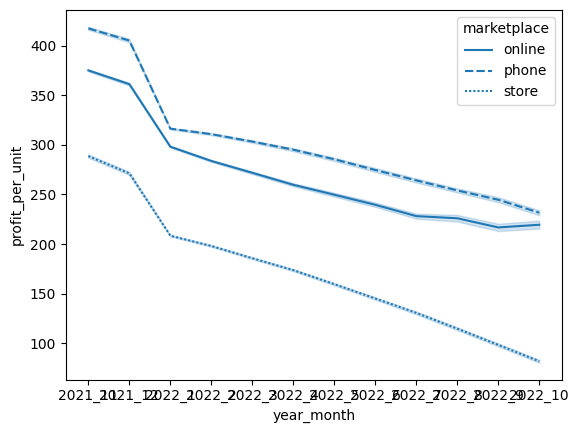

In [18]:
sns.lineplot(data=df_reg_main, x="year_month", y="profit_per_unit", style="marketplace")

Für alle Marktplätze ist erkennbar, dass die Gewinne pro Stück sinken. Jedoch sinken besonders die Stores deutlich rapider ab und besitzen von Anfang an einen niedrigeren Gewinn pro Stück.

Diese sinkende Tendenz in Stores bestärkt noch einmal die Korrelation zwischen der Verkaufsmenge des Tablet Pros und dem sinkenden Gewinn in Stores.

Zuletzt untersuchen wir, welche Fälle von Verlusten es über die Marktplätze hinweg gab.

In [9]:
# Show the amount of transactions per product and marketplace where the profit is negative
df_reg_main[df_reg_main['profit'] < 0].groupby(['product', 'marketplace'])['transaction_id'].count()

product       marketplace
Tablet Basic  online           60
              phone            18
              store          1100
Name: transaction_id, dtype: int64

Hierbei erkennen wir, dass nur das Tablet Basic als einziges Produkt Verluste erwirtschaftet. Die meisten solcher negativen Transaktionen wurden in Stores verzeichnet.

Weitergehend sollte also auch das Tablet Basic noch einmal weiter untersucht werden, da es in allen Marktplätze zu Verlusten führt.